# LIBRARIES AND DATA

In [1]:
import numpy as np # math stuff
import pandas as pd # data processing, CSV file I/O 
import matplotlib.pyplot as plt #plots and stuff
import seaborn as sns  #more plots and stuff


# Reset display.max_rows to default
pd.reset_option('display.max_rows')

# Reset display.max_columns to default
pd.reset_option('display.max_columns')

This data set contains all these sales from 2011 up to 2016 (a whopping 1941 days, which 1913 could be used for training and the last 28 for model evaluation). With all this data we could forecast with our model the sales in 3 different scopes of this hierarchy (An emphasis is placed on the first two points which seem the most relevant ones):

Sales of all the stores
Sales of each state
Sales of each store

In [3]:
#Calendar has a lot of Null data involving the events
calendarDF = pd.read_csv("data/calendar.csv")
calendarDF = calendarDF.loc[0:1000]

sellpricesDF = pd.read_csv("data/sell_prices.csv")
sellpricesDF = sellpricesDF.loc[0:1000]

submissionDF = pd.read_csv("data/sell_prices.csv")
submissionDF = submissionDF.loc[0:1000]

salestrainEVALDF = pd.read_csv("data/sales_train_evaluation.csv")
salestrainEVALDF = salestrainEVALDF.loc[0:1000]

salestrainVALDF  = pd.read_csv("data/sales_train_validation.csv")
salestrainVALDF = salestrainVALDF.loc[0:1000]



#example of a data serie
print(salestrainVALDF.loc[0])
#print(calendarDF.loc[0])

id          HOBBIES_1_001_CA_1_validation
item_id                     HOBBIES_1_001
dept_id                         HOBBIES_1
cat_id                            HOBBIES
store_id                             CA_1
                        ...              
d_1909                                  1
d_1910                                  3
d_1911                                  0
d_1912                                  1
d_1913                                  1
Name: 0, Length: 1919, dtype: object


# Pre-Processing

In this section, I'm going to show you how I preprocessed the raw data to make it usable and friendly before doing our Exploratory Data Analysis. The main things I've modified are data types that are incorrect (Such as dates with type object) and looked up for missing data or duplicates which will be extracted out of our data set.

In [4]:
#calendar missing data and duplicates search
#calendarDF['date'] = pd.to_datetime(calendarDF['date'])
calendarDF.dtypes
print('\n' + "----------------" + "\n")
calendarDF.isna().sum()
print('\n' + "----------------" + "\n")
sum(calendarDF.duplicated())

#sell prices missing data and duplicates search
sellpricesDF.dtypes
print('\n' + "----------------" + "\n")
sellpricesDF.isna().sum()
print('\n' + "----------------" + "\n")
sum(sellpricesDF.duplicated())

#train missing data and duplicates search
salestrainVALDF.dtypes
print('\n' + "----------------" + "\n")
salestrainVALDF.isna().sum()
print('\n' + "----------------" + "\n")
sum(salestrainVALDF.duplicated())


----------------


----------------


----------------


----------------


----------------


----------------



0

Since there are no duplicates nor null values that we really should worry about we can proceed to take a look into feature understanding. But firstly let's reduce the size and memory usage of the dataframes by downcasting them columns into smaller data types.

In [5]:
def reduce(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

In [6]:
# we will apply downcasting in order to reduce the memory usage (casting into smaller types)
calendarDF = reduce(calendarDF)
sellpricesDF = reduce(sellpricesDF)
submissionDF = reduce(submissionDF)
salestrainEVALDF = reduce(salestrainEVALDF)
salestrainVALDF = reduce(salestrainVALDF)

<ipython-input-5-dc9a18a38ed9>:21: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif t == np.object:


Exploratory Data Analysis
The aim of this section is to dissect into the data and find out relations between varibales , information that can be relevant in order to gain familiarity with the data set and test some assumptions which will help in our modeling. In order to do this exploration we first need to think about the data and make some hypotheses about what factors are influencing the sales, when they are expected to drop or to sky rocket. My initial hypotheses are the following:

LOCATION: Since prices change in each state, some state with higher cost of living can sell even more (due to price insensitivty)
CATEGORY: Some categories such as food will probably have more unit sells than household
PRICE: The more expensive a product is the less sales (probably) will be done
DAY: There will be a week "Seasonality" due to weekends being the 2 days that most people tend to buy
HOLIDAY: Depending on the event the number of sells can increase on certain categories (For instance in halloween the foods and housing units sold may rise) and they usually tend to rise with every single holiday, so a boost in sales will probably be seen in each holiday due to consumism and other factors.
For a quick reference, the holidays we are working with are the following:

In [7]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = calendarDF[['event_name_1']].dropna()
print(df['event_name_1'].unique())

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

['SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart', 'LentWeek2', ..., 'Chanukah End', 'NewYear', 'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter']
Length: 30
Categories (30, object): ['SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart', ..., 'NewYear', 'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter']


Exploring stores and states
We are going to take a closer look into then data related to the stores in order to ask some questions such as:

Which state sells the most?
Which category has the highest sells?
Which is the top best performing store?

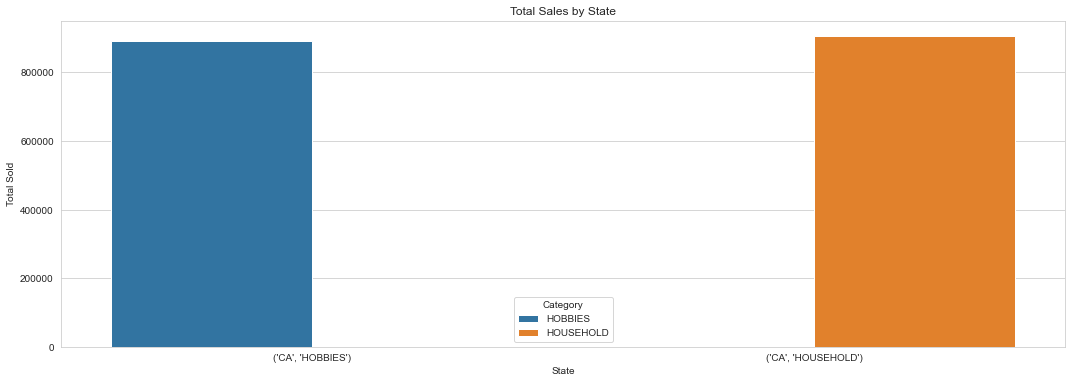

In [8]:
#Auxiliary data frame to fit all the sales information for state and category of items
#We will need a new feature 

columns = ['item_id' , 'dept_id','store_id']
aux = salestrainEVALDF.drop(columns,axis=1)


aux = aux.groupby(['state_id' , 'cat_id']).sum()
aux['col'] = aux.index
aux = aux.reset_index('cat_id')
aux['total_sold'] = aux.sum(axis=1)

sns.set_style("whitegrid")
plt.figure(figsize=(18, 6))
salesPlot = sns.barplot(data=aux, x='col' , y='total_sold', hue='cat_id')#, width = 0.3)
salesPlot.legend(title = 'Category')
salesPlot.set_xlabel('State')
salesPlot.set_ylabel('Total Sold')
salesPlot.set_title('Total Sales by State')
plt.ticklabel_format(style='plain', axis='y')

As we can see california is the state which sells the most and also we can conclude that the foods category is by far the one that get the most sells in each state , which was totally expected. From these conclusions we can see that maybe will be useful to add to the feature of total sales for each row (Remember that each row consisted of a product of a certain category on a specific store), and also the sum of all the items of a category on a certain state. Following up we will see which department has the highest sells and which one is it:

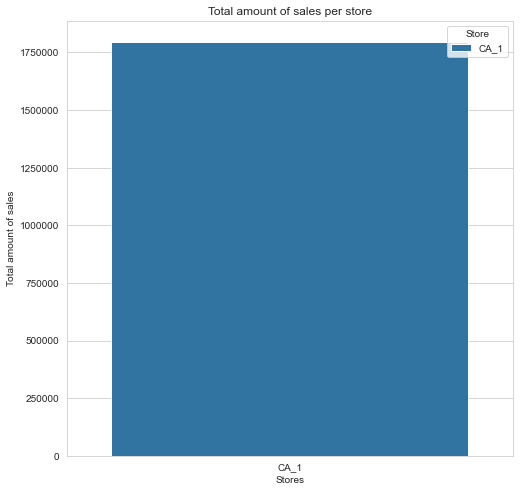

In [9]:
columns = ['item_id','state_id','cat_id', 'dept_id']
aux = salestrainEVALDF.drop(columns,axis=1)


aux = aux.groupby(['store_id']).sum()
aux['col'] = aux.index
aux = aux.reset_index('store_id')
aux['total_sold'] = aux.sum(axis=1)

sns.set_style("whitegrid")
plt.figure(figsize=(8, 8))
salesPlot = sns.barplot(data=aux, x='col' , y='total_sold', hue='store_id')
salesPlot.legend(title = 'Store')
salesPlot.set_xlabel('Stores')
salesPlot.set_ylabel('Total amount of sales')
salesPlot.set_title('Total amount of sales per store')
plt.ticklabel_format(style='plain', axis='y')

It's crystal clear that California is the state that sold the most but both texas and winsconsin sold similar amounts of items with winsconsin being at the bottom.

Exploring prices and departments
In this section, a further detail will be placed into which variables affect prices. Also, the categories and departments variables will be explored in further detail. The main questions that will be answered:

How expensive are the items of a department (in average) ?
Which department has the widest range of items?
Which department sells the most of them all?

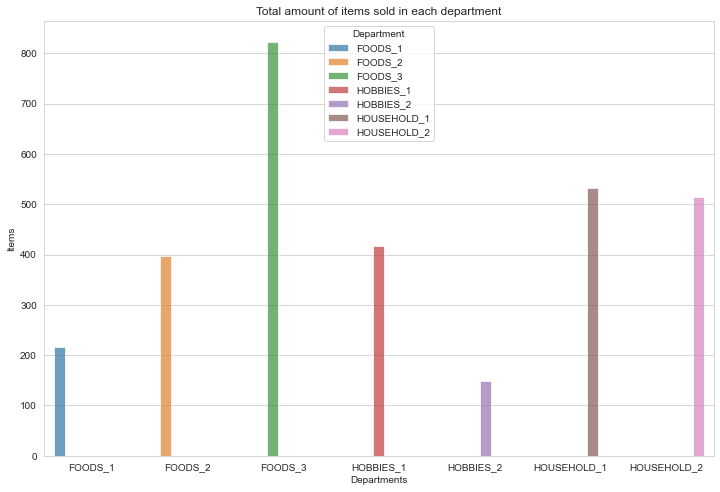

In [10]:
aux = salestrainEVALDF[['dept_id','item_id']]
aux = aux.groupby(['dept_id']).nunique().reset_index()
aux = aux.rename(columns={'item_id': 'ItemCount', 'dept_id': 'Department'})

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
itemsPlot = sns.barplot(data=aux, x='Department' , y='ItemCount', hue='Department',alpha=0.7)
itemsPlot.set_xlabel('Departments')
itemsPlot.set_ylabel('Items')
itemsPlot.set_title('Total amount of items sold in each department')
plt.ticklabel_format(style='plain', axis='y')

As we can see again, the one with the highest amount of items, it's the food department. On the upcoming graph, we are going to check up the mean price of a product in a specific department. Taking a look at the describe command, we can see that the average price of a product is 4.41 but there are outliers:

In [11]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sellpricesDF.describe()
#uncomment to see the structure of the sell prices data frame 
#sellpricesDF.head()

,wm_yr_wk,sell_price
count,6841121.00,6841121.00
mean,11382.94,nan
std,148.61,0.00
min,11101.00,0.01
25%,11247.00,2.18
50%,11411.00,3.47
75%,11517.00,5.84
max,11621.00,107.31


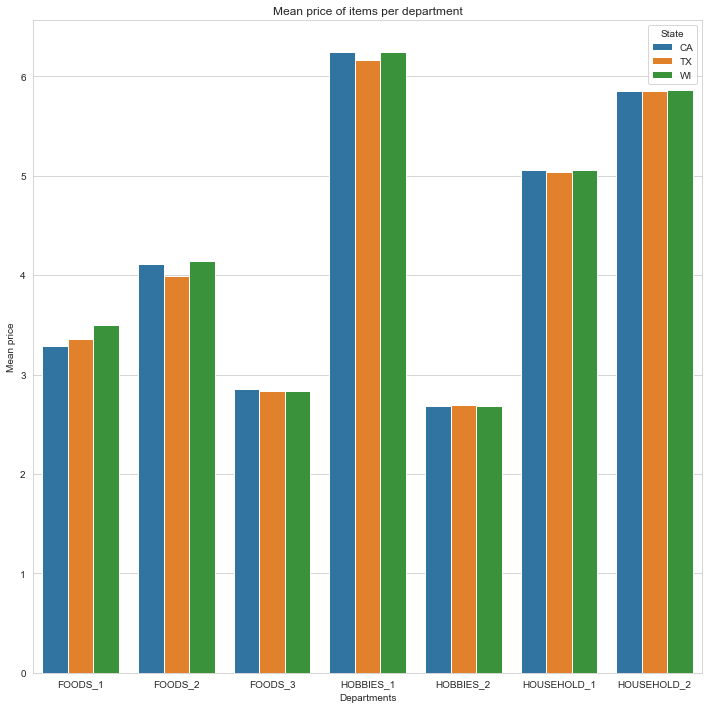

In [12]:
#auxiliary functions that will be usefull
def map_state(store_id):
    if store_id.startswith('CA'):
        return 'CA'
    elif store_id.startswith('WI'):
        return 'WI'
    elif store_id.startswith('TX'):
        return 'TX'
    else:
        return None
    
def map_dept(item_id):
    if item_id.startswith('HOBBIES_1'):
        return 'HOBBIES_1'
    elif item_id.startswith('HOBBIES_2'):
        return 'HOBBIES_2'
    elif item_id.startswith('FOODS_1'):
        return 'FOODS_1'
    elif item_id.startswith('FOODS_2'):
        return 'FOODS_2'
    elif item_id.startswith('FOODS_3'):
        return 'FOODS_3'
    elif item_id.startswith('HOUSEHOLD_1'):
        return 'HOUSEHOLD_1'
    elif item_id.startswith('HOUSEHOLD_2'):
        return 'HOUSEHOLD_2'
    elif item_id.startswith('HOUSEHOLD_3'):
        return 'HOUSEHOLD_3'
    else:
        return None

##PENDING
def map_cat(item_id):
    if item_id.startswith('HOBBIES'):
        return 'HOBBIES_1'
    elif item_id.startswith('HOBBIES_2'):
        return 'HOBBIES_2'
    elif item_id.startswith('FOODS_1'):
        return 'FOODS_1'
    elif item_id.startswith('FOODS_2'):
        return 'FOODS_2'
    elif item_id.startswith('FOODS_3'):
        return 'FOODS_3'
    elif item_id.startswith('HOUSEHOLD_1'):
        return 'HOUSEHOLD_1'
    elif item_id.startswith('HOUSEHOLD_2'):
        return 'HOUSEHOLD_2'
    elif item_id.startswith('HOUSEHOLD_3'):
        return 'HOUSEHOLD_3'
    else:
        return None
    
x = sellpricesDF[['store_id', 'item_id', 'sell_price']]
x['state_id'] = x['store_id'].apply(map_state)
x['dept_id'] = x['item_id'].apply(map_dept)
x = x.set_index('dept_id')
ay = x.groupby(['dept_id','state_id']).mean().reset_index()
ay = ay.rename(columns={'sell_price': 'MeanSellPrice','dept_id': 'Department', 'state_id': 'State'})


plt.figure(figsize=(12, 12))
sns.set_style("whitegrid")
itemsPlot = sns.barplot(data=ay, x='Department' , y='MeanSellPrice', hue='State',alpha=1)
itemsPlot.set_xlabel('Departments')
itemsPlot.set_ylabel('Mean price')
itemsPlot.set_title('Mean price of items per department')
plt.ticklabel_format(style='plain', axis='y')

Mean prices in the household and hobbies department tend to be higher than the food ones (HOBBIES_1 being the most expensive followed by HOUSEHOLD_2). We can also guess that california and winsconsin have the most expensive items in average. Finally, the number of sells per department, which can be visualized in the following plot, reinforces even more the initial hypotheses that the food sector is the one that sells the most and also the assumption that consumism in california is higher (This could be due to the size of the states , which are: 38 million (CA), 25 million (TX), 5.7 million (WI)

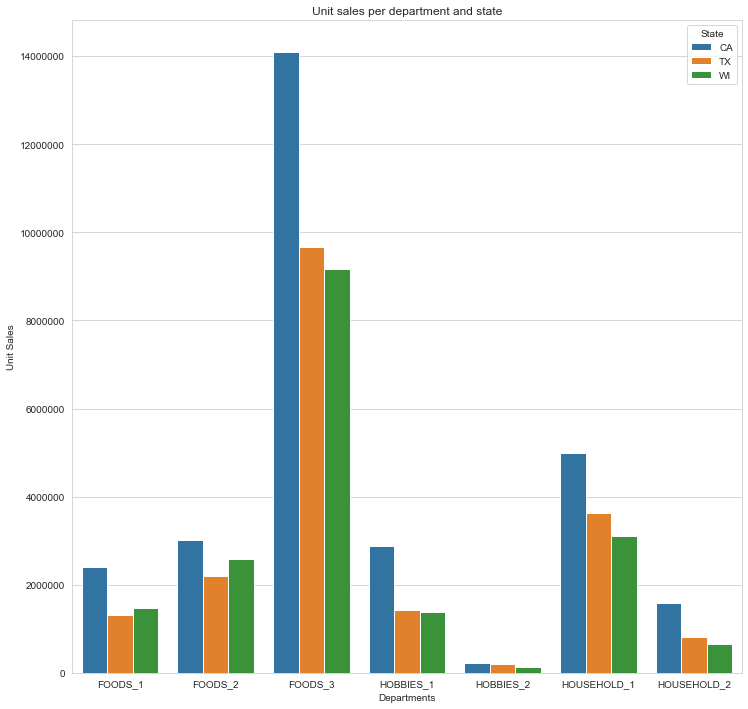

In [13]:
columns = ['item_id' ,'store_id']
aux = salestrainEVALDF.drop(columns,axis=1)


aux = aux.groupby(['state_id' , 'dept_id']).sum()
aux['TotalSold'] = aux.sum(axis=1)
aux = aux.reset_index()
aux = aux[['dept_id', 'state_id', 'TotalSold']]
aux = aux.rename(columns={'dept_id': 'Department', 'state_id': 'State'})

plt.figure(figsize=(12,12))
Plot = sns.barplot(data = aux, x = 'Department', y = 'TotalSold', hue = 'State')
Plot.set_xlabel('Departments')
Plot.set_ylabel('Unit Sales')
Plot.set_title('Unit sales per department and state')
plt.ticklabel_format(style='plain', axis='y')

Exploring trends on events and holidays¶
Now we should figure out the impact the special days has on the amount of sells just before going into the most important section, the seasonality and time series analysis. Important questions are the ones such as:

Which events had the most substantial effect on sales?

How do these kinds of days affect the sales?

Do any special day impact the sales in a negative way?

For this section it's of great importance to reshape the main dataFrame we are using so we can analyize it better and possibly use it later for the training of our model just adding a few features. Since the amount of data is so huge, we need to cut it down (for example we are just keeping 10% of the original data, but if we had more ram aviable we could use more) but preserving the sampling properties so the population chosen has a low bias, that can be done using stratified sampling. This kind of sampling reflects the overall population since it stratifies the data into different groups before random sampling the population.

In [10]:
id_vars = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]

#Melting the salestrainEVALDF to obtain columns for days and unit sales
trainData = pd.melt(salestrainEVALDF, id_vars=id_vars, var_name="day", value_name="unit_sales")

#Left join operation is performed on the train set merging based on days 
data = pd.merge(trainData, calendarDF, left_on='day', right_on='d', how='left')

#stratify data by item and month 
from sklearn.model_selection import StratifiedShuffleSplit

data.dropna(subset=["item_id", "month"], inplace=True)

stratifier = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in stratifier.split(data, data["item_id"], data["month"]):
    data = data.iloc[test_index]
    
#apply a Left Join operation on the store/item/week with the sales
data = pd.merge(data, sellpricesDF, left_on=['store_id', 'item_id', 'wm_yr_wk'],right_on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

# Print the merged DataFrame to verify the results
print(data.tail())

# we now got a huge data frame that contains the 1941 days

                                     id          item_id      dept_id  \
100196  HOUSEHOLD_1_047_CA_1_evaluation  HOUSEHOLD_1_047  HOUSEHOLD_1   
100197  HOUSEHOLD_1_430_CA_1_evaluation  HOUSEHOLD_1_430  HOUSEHOLD_1   
100198  HOUSEHOLD_1_069_CA_1_evaluation  HOUSEHOLD_1_069  HOUSEHOLD_1   
100199  HOUSEHOLD_1_315_CA_1_evaluation  HOUSEHOLD_1_315  HOUSEHOLD_1   
100200    HOBBIES_1_214_CA_1_evaluation    HOBBIES_1_214    HOBBIES_1   

           cat_id store_id state_id    day  unit_sales       date  wm_yr_wk  \
100196  HOUSEHOLD     CA_1       CA  d_264           0 2011-10-19   11138.0   
100197  HOUSEHOLD     CA_1       CA   d_81           0 2011-04-19   11112.0   
100198  HOUSEHOLD     CA_1       CA  d_974          10 2013-09-28   11336.0   
100199  HOUSEHOLD     CA_1       CA  d_190           0 2011-08-06   11128.0   
100200    HOBBIES     CA_1       CA  d_694           0 2012-12-22   11248.0   

        ...    year      d  event_name_1  event_type_1 event_name_2  \
100196  ...  20

Following up we will compare how much each holiday affected the sales sector and which day was the one with the highest sales:

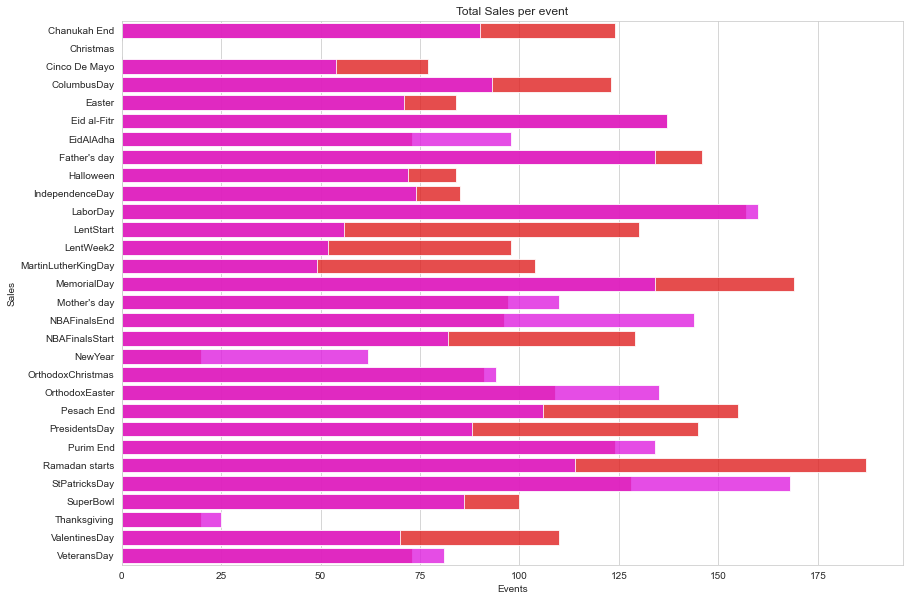

In [11]:
events_name1 = data[data['event_name_1'] != 'None']
events_type1 = data[data['event_type_1'] != 'None']
#graph = events_name1.groupby(['event_name_1', 'cat_id'])['unit_sales'].sum().reset_index()

custom_palette = ["#FF0000", "#FF00FF", "#00FFFF"]  
sns.set_palette(custom_palette)
plt.figure(figsize=(14, 10))
g = sns.barplot(data=events_name1, x = 'unit_sales', y = 'event_name_1', hue = 'cat_id', alpha = 0.8, estimator = sum, ci = None, orient = 'h', dodge=False)
g.set_xlabel('Events')
g.set_ylabel('Sales')
g.set_title('Total Sales per event')
#it's kind of bugged
g.legend_.remove()

plt.show()

As we can see the most profitable day in almost every category is the SuperBowl, and the least is Christmas (Because the stores are closed we migth guess) (Red corresponds to food, blue to hobbies and cyan to household). Next up, we are going to analyze the plots in a monthly manner of the sales of each year, in order to clearly interpret how do they affect at the overall performance of the stores:

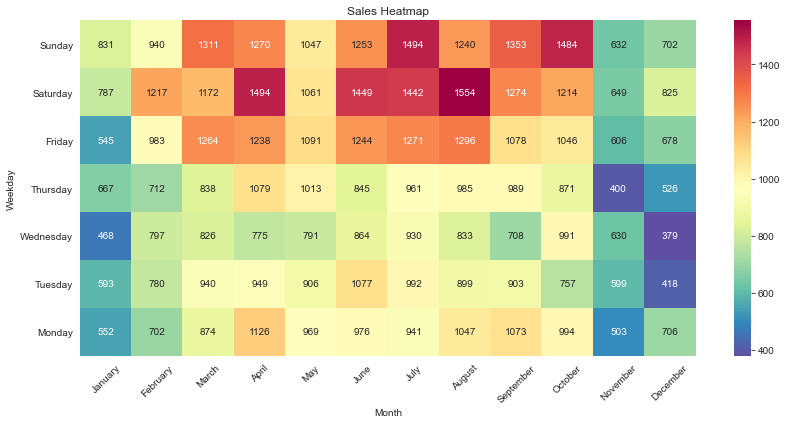

In [12]:
import calendar
data['wday'] = data['date'].dt.day_name()
data['month'] = data['date'].dt.month_name()
data['year'] = data['date'].dt.year
heatmap_data = data.groupby(['wday', 'month', 'year']).sum('unit_sales').reset_index()
heatmap_data = heatmap_data.groupby(['wday', 'month']).sum('unit_sales').reset_index()

heatmap_table = heatmap_data.pivot(index='wday', columns='month', values='unit_sales')

weekday_order = ['Sunday', 'Saturday', 'Friday', 'Thursday','Wednesday','Tuesday','Monday'  ]
heatmap_table = heatmap_table.reindex(index=weekday_order)

month_order = [calendar.month_name[i] for i in range(1, 13)]
heatmap_table = heatmap_table.reindex(columns=month_order)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_table, cmap='Spectral_r', annot=True, fmt='.0f', cbar=True)
plt.title('Sales Heatmap')
plt.xlabel('Month')
plt.ylabel('Weekday')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

After all these observations we can conclude that somes special days such as christmas, the sales drop to 0 because the store is close. Also on some festivals like easter, new year... The highest volume of selling is done on the weekends and the first months before june are the most profitable too. We can conclude that some days such as thursday, tuesday and wednesday are the worst speaking of raw sales.

Exploring time series and seasonalities
This section will answer a bunch of questions related to the seasonality of the sales, which days, weeks and months are the most profitable and which ones are the least. The most important questions are the following:

Which is the time series of the days? Which days are the most profitable?
Which days of the week are the most profitable (where most people buy the groceries)?
Which month got the highest sales and which one got the lowest?
Which are the trends for each state ?
Firstly, we will see the overall trend of each day for the 5-year period of the sales per each state and per category. As we will see on the plot there's a clear pattern , where the sales are usually in a range but some special days got massive spikes (Which most of them are holidays or weekends). The food category comes on top and also California it's unsurprisingly the state which sells the most and has the biggest spikes (probably on event or special days)

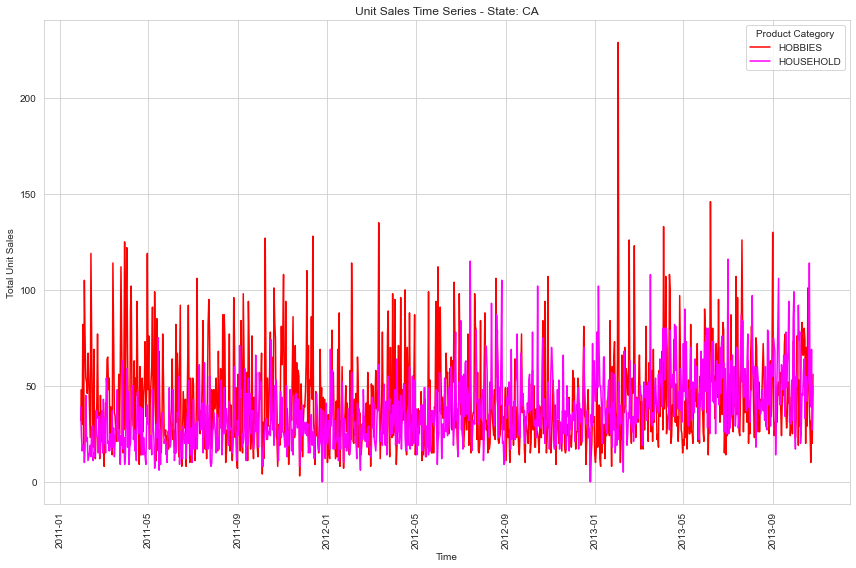

In [17]:
newdata = data[['state_id', 'cat_id', 'date', 'unit_sales', 'month', 'year']].groupby(['state_id', 'cat_id', 'date']).sum().reset_index()

# Get state IDs
state_ids = newdata['state_id'].unique()

# Calculate the figure size
fig_width = 12 * len(state_ids)
fig_height = 8

# Create the figure
fig, axes = plt.subplots(1, len(state_ids), figsize=(fig_width, fig_height), sharey=True)

# Iterate over each state and plot them individually, so then can be merged into one big plot
for i, state_id in enumerate(state_ids):
    state_data = newdata[newdata['state_id'] == state_id]
    
    ax = axes
    sns.lineplot(data=state_data, x='date', y='unit_sales', hue='cat_id', ax=ax)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Total Unit Sales')
    ax.set_title(f'Unit Sales Time Series - State: {state_id}')
    ax.legend(title='Product Category')
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

I personally think that is easier to understand using a weekly day time series plot like the following, which completly confirms our hypothesis that weekends have the highest sales (And also confirms that people in winsconsin buy more on saturday rather than sunday, which could tell us a thing or two about people from winsconsin and their habits, they may be more religious or use sunday as their restday...). The 3 days with the least volume sold are tuesday, wednesday and thursday

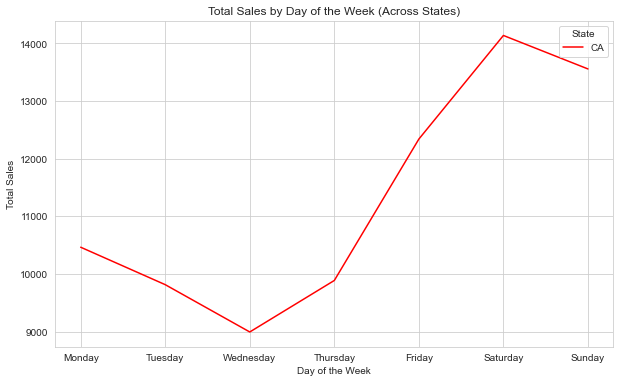

In [18]:
grouped_data = data.groupby(['wday', 'state_id'])['unit_sales'].sum().unstack()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped_data = grouped_data.reindex(weekday_order)

plt.figure(figsize=(10, 6))
for state_id, state_data in grouped_data.iteritems():
    plt.plot(state_data, label=state_id)

plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.title('Total Sales by Day of the Week (Across States)')
plt.legend(title='State')

plt.ticklabel_format(style='plain', axis='y')
plt.show()

Following up we are going to generate a monthly heatmap for one year to better understand what's going on the last plot (It's hard to visualize it) where we are going to confirm our hypothesis that weekends sell more than the other days on the week, and that some special days have lower sales (such as thanksgiving, new years eve) probably due to people not buying or reduced working hours.

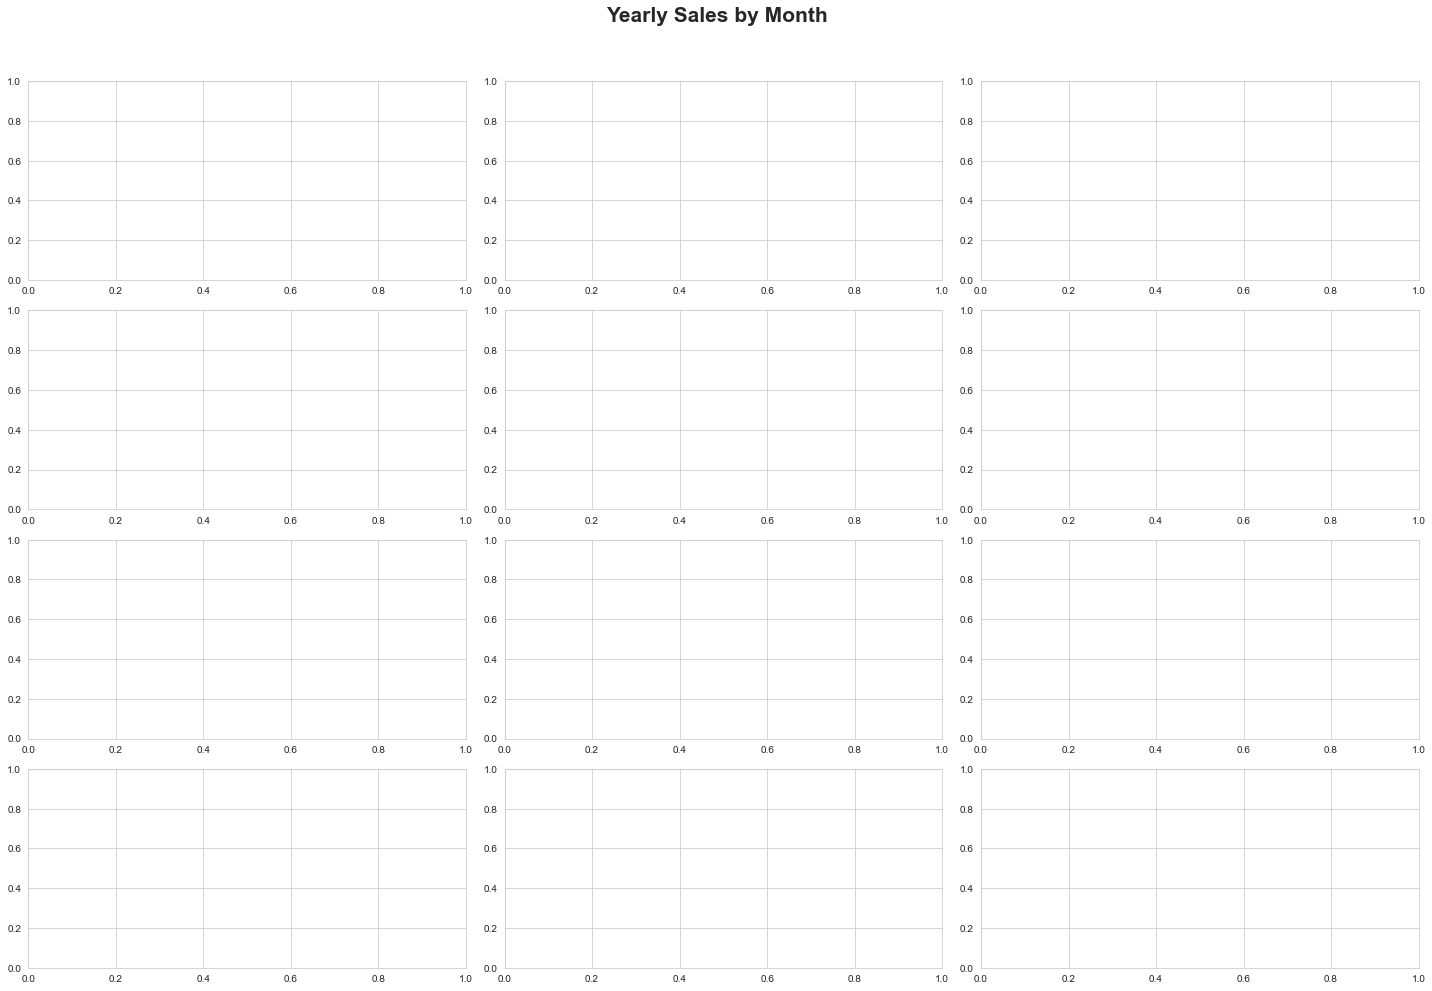

In [19]:
heat = data[['date', 'unit_sales', 'wday']].copy()
heat['month'] = heat['date'].dt.month_name()
heat['week'] = heat['date'].dt.isocalendar().week

heat = heat[heat['date'].dt.year == 2015]
grouped_data = heat.groupby('month')

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 14))
fig.suptitle('Yearly Sales by Month', fontsize=21, fontweight='bold')

sorted_data = sorted(grouped_data, key=lambda x: month_order.index(x[0]))

for (month, month_data), ax in zip(sorted_data, axes.flatten()):
    month_data = month_data[month_data['month'] == month]  # Filter data for the current month
    heatmap_data = month_data.groupby(['week', 'date', 'wday'])['unit_sales'].sum().reset_index()
    heatmap_table = heatmap_data.pivot(index='week', columns='wday', values='unit_sales')
    
    sorted_heatmap_table = heatmap_table[weekday_order]  # Sort the heatmap_table based on weekday_order
    sorted_heatmap_table = sorted_heatmap_table.iloc[::-1]  # Reverse the row order
    
    sns.heatmap(sorted_heatmap_table, cmap='flare', annot=True, fmt='.0f', cbar=True, ax=ax, vmin=0, vmax=6000,
                xticklabels=weekday_order)  # Set the custom order of weekdays
    
    ax.set_title(month, fontweight='bold')
    ax.set_xlabel('Weekday')
    ax.set_ylabel('Week')
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='both', length=0)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Now we will analyze the time series in a monthly and weekly fashion with a time series graph and finally a heatmap that will be more visually appealing to understand all this information at once.

<ipython-input-20-65eb3b861204>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g['month'] = pd.DatetimeIndex(g['date']).month


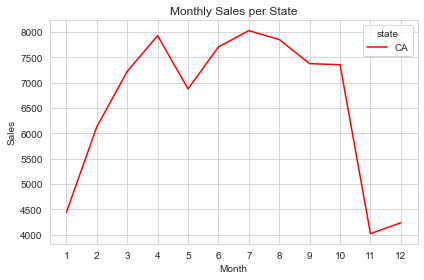

In [20]:
#MONTHLY
g = data[['date', 'state_id', 'cat_id', 'unit_sales']]
g['month'] = pd.DatetimeIndex(g['date']).month
g = g.groupby(['month', 'state_id']).sum('unit_sales').reset_index()

plt.figure()
for state_id, group_data in g.groupby('state_id'):
    plt.plot(group_data['month'], group_data['unit_sales'], label=state_id)

plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales per State')
plt.legend(title='state')
plt.xticks(range(1, 13), fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

As we can see, the 3 most profitable months are on january, february and march for some reason. The news years eve may have an impact and the high number of festivities taking place those months (for instance the super bowl takes places usually at the first two weeks of february).

<ipython-input-21-7915e937f5b0>:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  g['week'] = pd.DatetimeIndex(g['date']).week
<ipython-input-21-7915e937f5b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g['week'] = pd.DatetimeIndex(g['date']).week


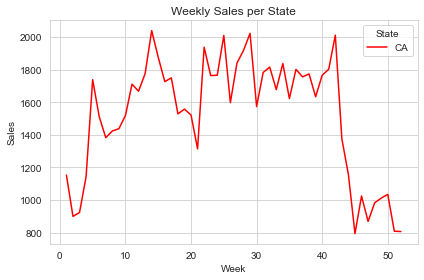

In [21]:
g = data[['date', 'state_id', 'cat_id', 'unit_sales']]
g['week'] = pd.DatetimeIndex(g['date']).week
g = g.groupby(['week', 'state_id']).sum('unit_sales').reset_index()

plt.figure()
for state_id, group_data in g.groupby('state_id'):
    plt.plot(group_data['week'], group_data['unit_sales'], label=state_id)

plt.xlabel('Week')
plt.ylabel('Sales')
plt.title('Weekly Sales per State')
plt.legend(title='State')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

It's obvious that the weekends are the most profitable days speaking of volume sold. Some states peak on different days of the week, such as winsconsin which drastically peaks and goes down on sundays (that detail right there tells us about the habits of people in winsconsin on where probably people prefer resting and spending time with the family rather than buying groceries at a walmart). Looking at the weekly and yearly time series we can definitely say that the first 5 months are great in terms of how much is sold and then it drops a bit for the rest of the year and completely plummets on the last week of the year due to christmas and new years eve festivities and also low sales in general.

Finally i wanted to conclude that each state follows, more or less, the same yearly pattern, so not much information can be extracted from this data.